In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [100]:
df = pd.read_csv('Data/processed.csv')
df.head()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,year,month,day,hour,cluster
0,2022-01-01,11.021500,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,2022,1,1,0,1
1,2022-01-01,10.521500,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,2022,1,1,1,1
2,2022-01-01,10.721499,96.0,8.677092,0.0,0.0,0.0,0.0,1019.8,1018.69610,100.0,14.345898,197.52567,39.96,0.0,2022,1,1,2,1
3,2022-01-01,11.071500,97.0,9.138726,0.0,0.0,0.0,0.0,1019.7,1018.59784,100.0,14.587776,195.75124,42.12,0.0,2022,1,1,3,1
4,2022-01-01,11.221499,96.0,8.969191,0.0,0.0,0.0,0.0,1019.5,1018.39825,100.0,16.766108,194.93147,49.32,0.0,2022,1,1,4,1


In [101]:
df.isna().sum()

date                    0
temperature_2m          0
relative_humidity_2m    0
apparent_temperature    0
precipitation           0
rain                    0
showers                 0
snowfall                0
pressure_msl            0
surface_pressure        0
cloud_cover             0
wind_speed_10m          0
wind_direction_10m      0
wind_gusts_10m          0
is_day                  0
year                    0
month                   0
day                     0
hour                    0
cluster                 0
dtype: int64

In [102]:
df.duplicated().sum()

0

### EDA

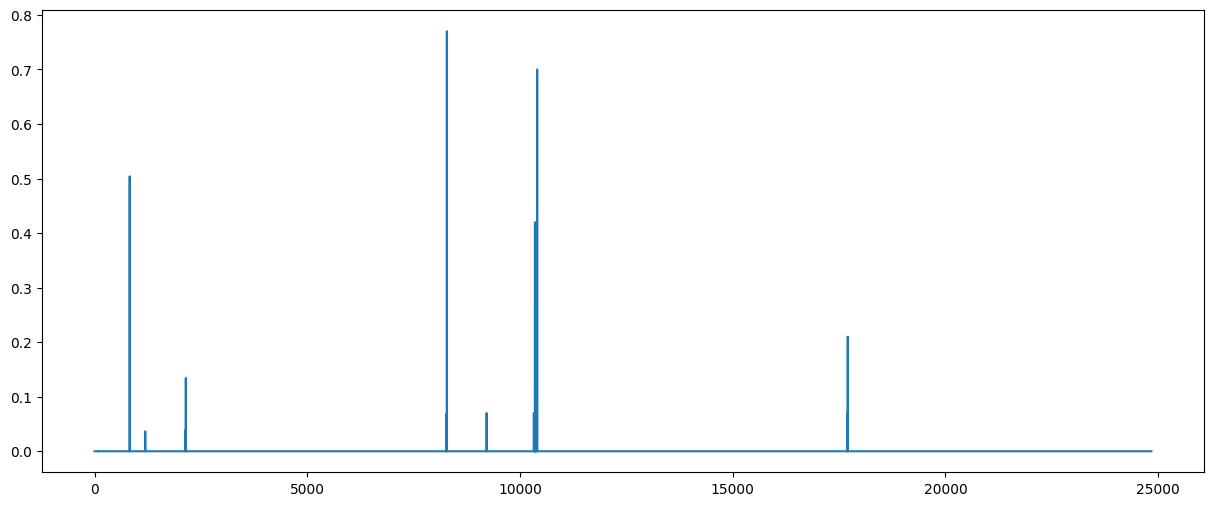

In [103]:
plt.figure(figsize=(15,6), dpi = 100) 
plt.plot(df['snowfall'], linestyle = 'solid') #solid, dashed, dashdot, dotted
plt.show()

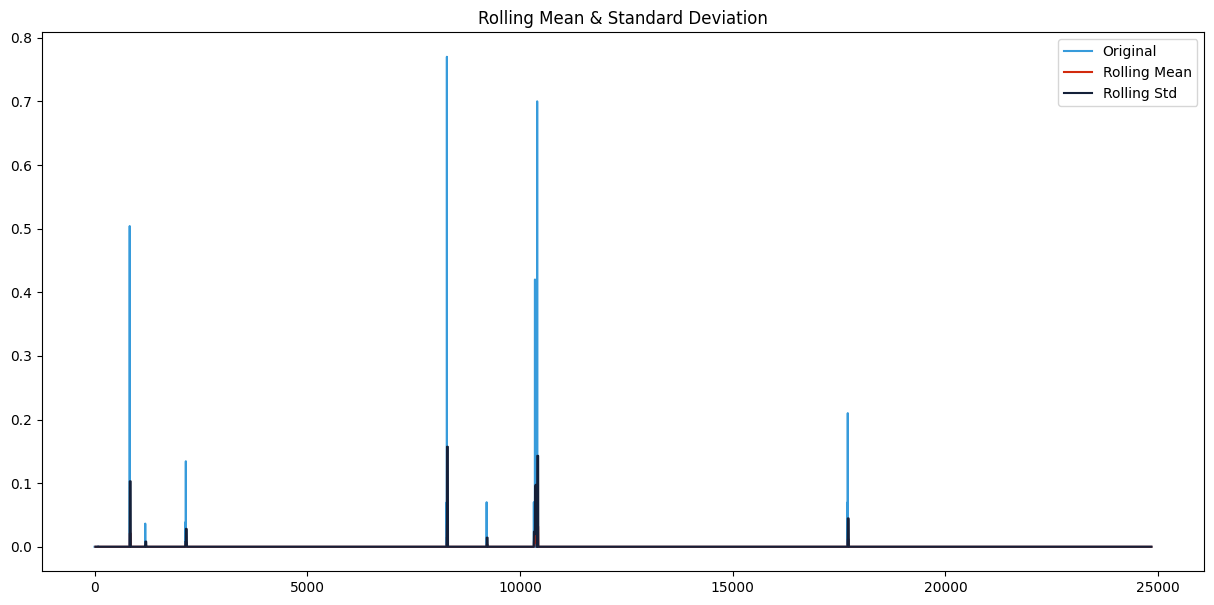

In [104]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["snowfall"], color='#379BDB', label='Original')
plt.plot(df["snowfall"].rolling(window=24).mean(), color='#D22A0D', label='Rolling Mean')
plt.plot(df["snowfall"].rolling(window=24).std(), color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

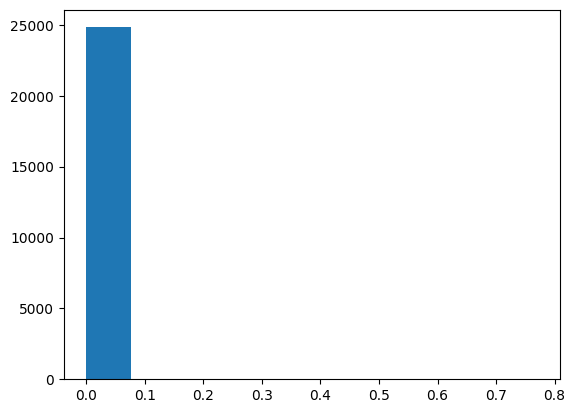

In [105]:
plt.hist(df['snowfall'])
plt.show()

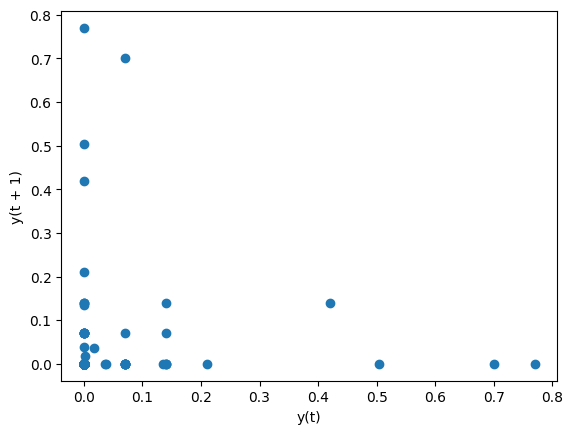

In [106]:
from pandas.plotting import lag_plot

lag_plot(df['snowfall'])
plt.show()

In [107]:
# Checking auto-correlation
from pandas import concat

btc_price = df['snowfall']
dataframe = concat([btc_price.shift(1), btc_price], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
result

,t,t+1
t,1.000000,0.082617
t+1,0.082617,1.000000


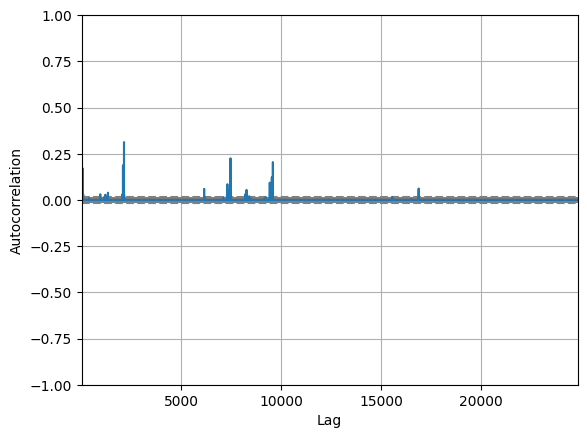

In [108]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['snowfall'])
plt.show()

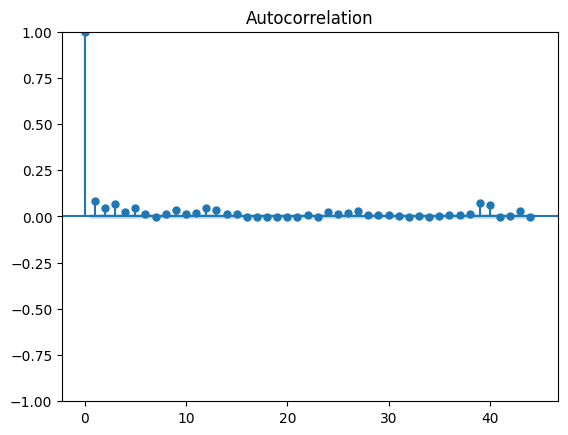

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['snowfall'])
plt.show()

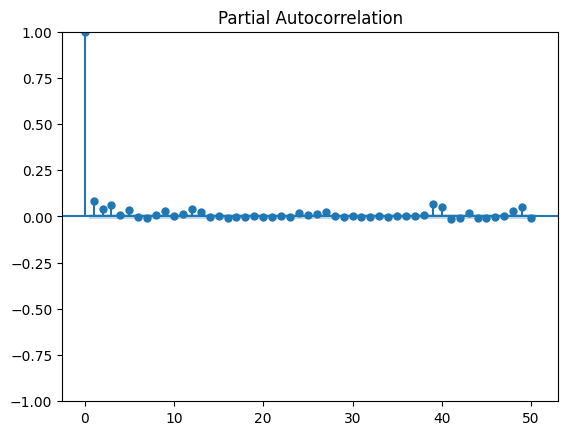

In [110]:
plot_pacf(df['snowfall'], lags=50)
plt.show()

### Data transformation

In [111]:
df = df.drop(['year', 'date'], axis = 1)
df.head(2)

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,month,day,hour,cluster
0,11.0215,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,1,1,0,1
1,10.5215,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,1,1,1,1


<Axes: >

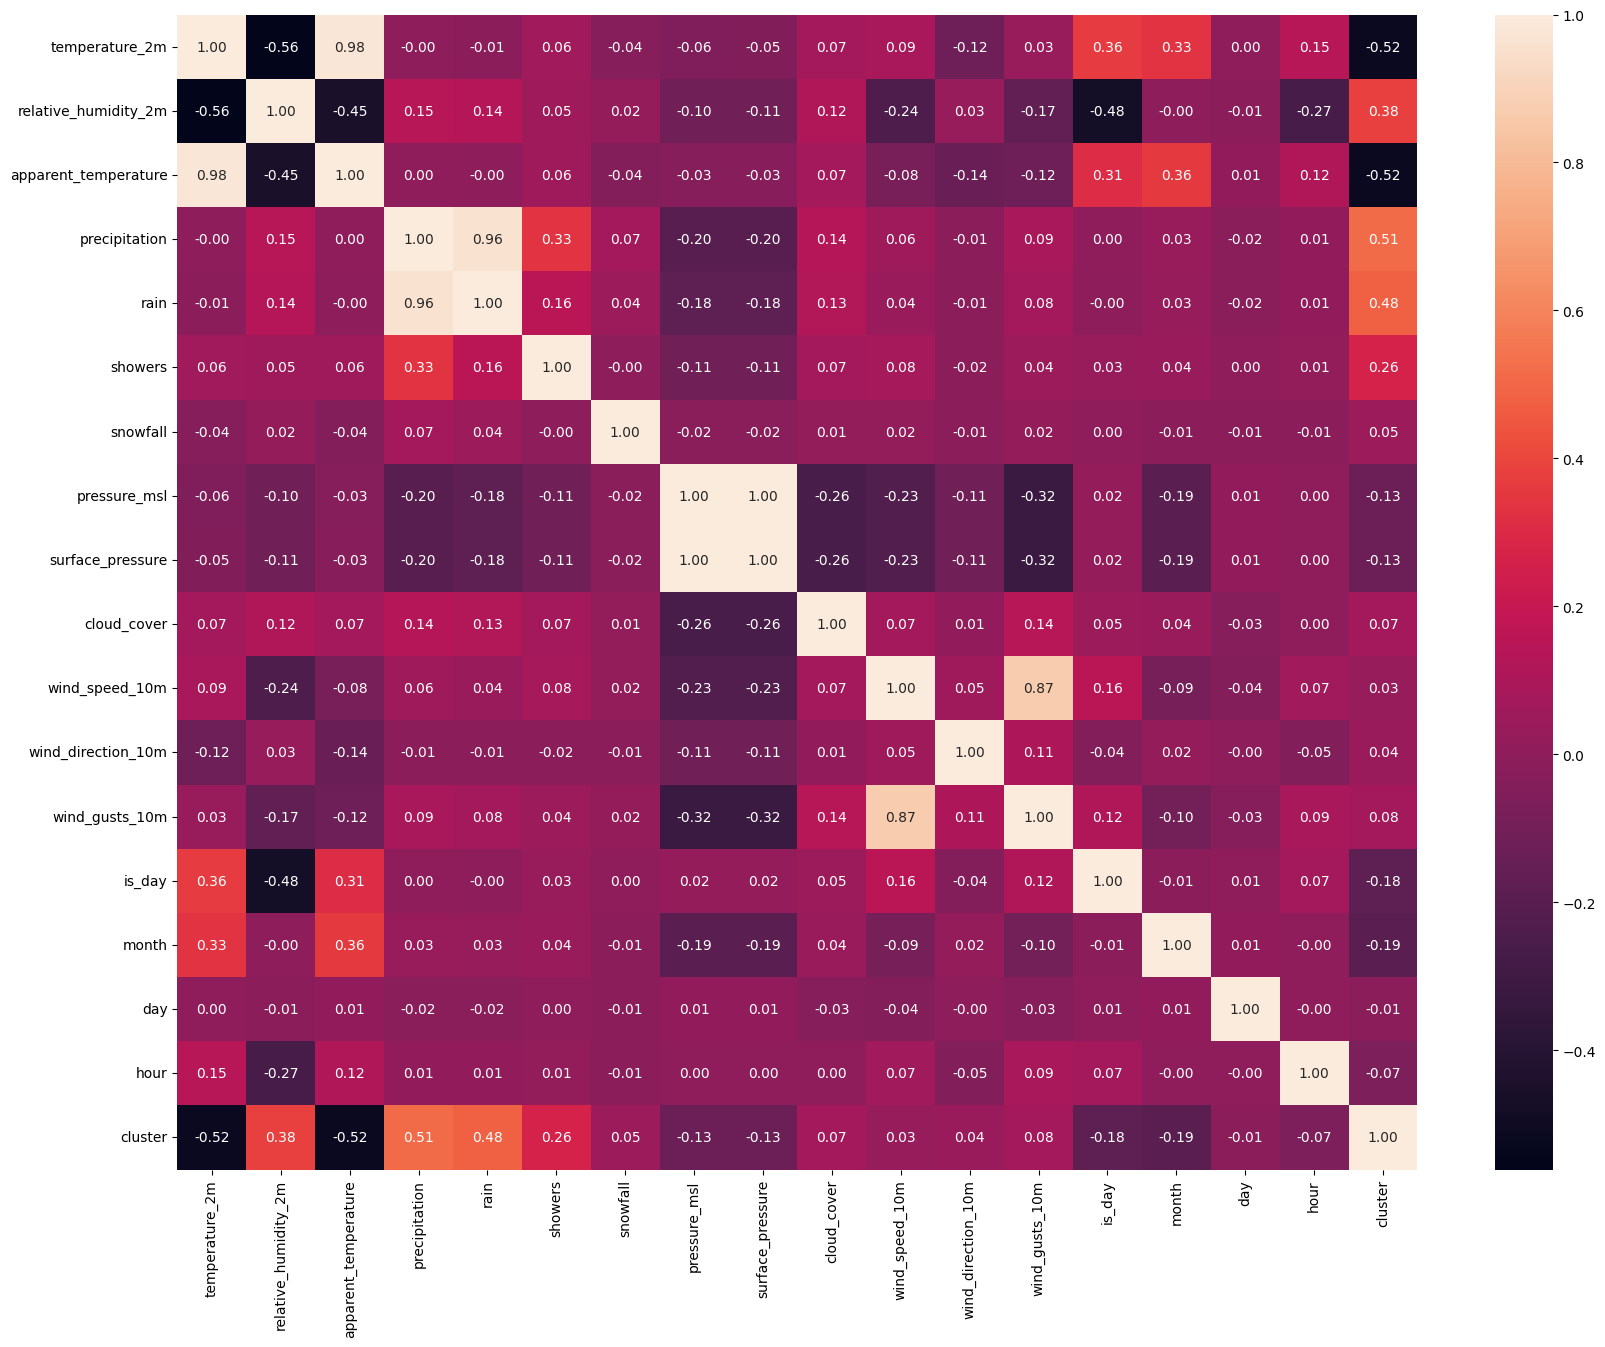

In [112]:
# Create correlation matrix heat map to check multi-collinearity between columns.

plt.figure(figsize = (20,15), dpi = 100)
sns.heatmap(df.corr(), annot = True, fmt = '.2f')

### Stationarity

In [113]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['snowfall'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -17.591602669403176
p-value: 3.961413869667922e-30


### Data Splitting and scaling

In [114]:
len(df.index) - (len(df.index) * 20 /100)

19872.0

In [115]:
train = df.iloc[:19872]
test = df.iloc[19872:]
test.reset_index(drop = True, inplace = True)

In [116]:
x_train = train.drop('snowfall', axis = 1)
y_train = train[['snowfall']]
x_test = test.drop('snowfall', axis = 1)
y_test = test[['snowfall']]

In [117]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19872, 17)
(19872, 1)
(4968, 17)
(4968, 1)


### Feature Selection

In [118]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the features
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [119]:
lasso = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso.fit(x_train, y_train)

C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7080728818891657, tolerance: 1.6693472373548808
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.610267211593964, tolerance: 1.6693472373548808
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\sklearn\linear_mode

C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9028019477009366, tolerance: 1.9304947115044733
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.716103357222892, tolerance: 1.9304947115044733
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.18656598716916, tolerance: 1.9304947115044733
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-package

LassoCV(cv=5, random_state=42)

In [120]:
# Get the coefficients
feature_names = list(train.columns)
feature_names.remove('snowfall')
lasso_coefficients = lasso.coef_

# Identify selected features
selected_features_indices = np.where(lasso_coefficients != 0)[0]
selected_feature_names = [feature_names[i] for i in selected_features_indices]
selected_coefficients = lasso_coefficients[selected_features_indices]

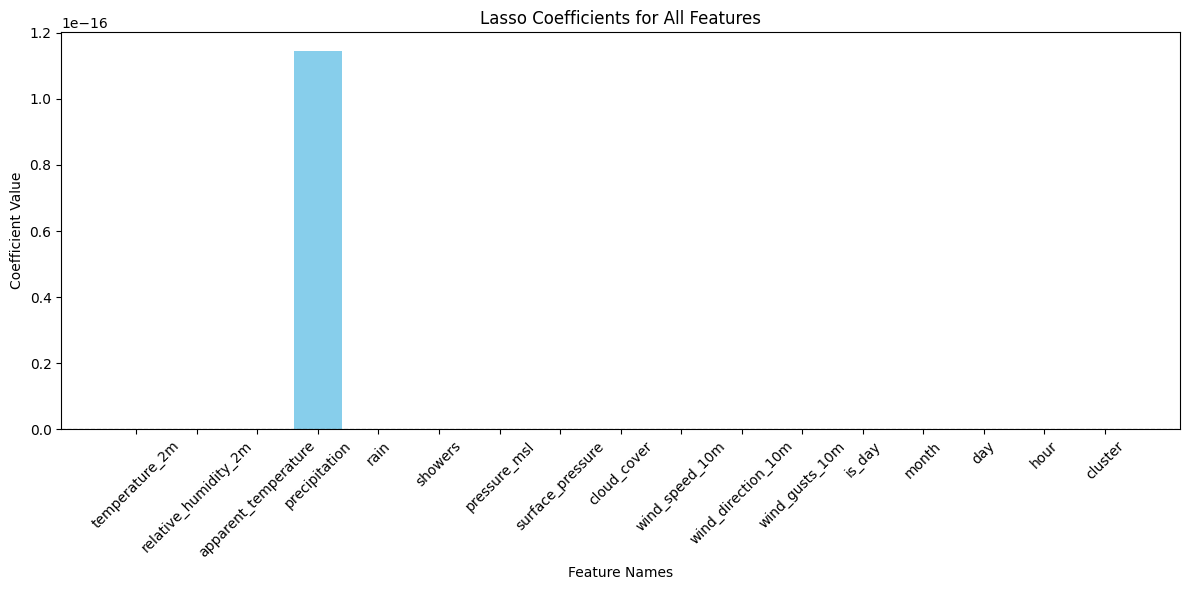

In [121]:
plt.figure(figsize=(12, 6))
plt.bar(feature_names, lasso_coefficients, color='skyblue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Lasso Coefficients for All Features")
plt.xlabel("Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

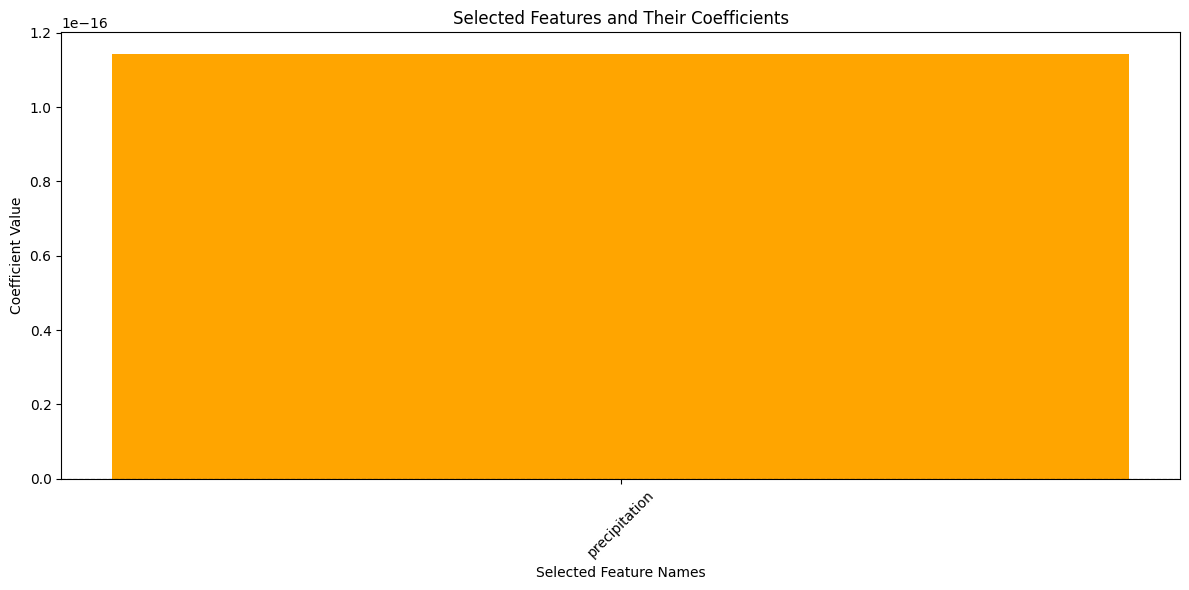

In [122]:
plt.figure(figsize=(12, 6))
plt.bar(selected_feature_names, selected_coefficients, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Selected Features and Their Coefficients")
plt.xlabel("Selected Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [123]:
selected_coefficients

array([1.1441912e-16])

In [124]:
selected_features_indices

array([3], dtype=int64)

In [125]:
x_train = x_train[:, selected_features_indices]
x_test = x_test[:, selected_features_indices]

### Machine learning

In [126]:
def mad_error(y_true, y_pred):
    # Ensure inputs are numpy arrays for vectorized operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate absolute deviations
    absolute_deviation = np.abs(y_true - y_pred)
    
    # Compute the mean of absolute deviations
    mad_error = np.mean(absolute_deviation)
    
    return mad_error

In [127]:
df1 = df[['snowfall', 'precipitation']]

In [128]:
lagged_data = df1.copy()
for lag in range(1, 2):  # Create lags
    for col in df1.columns:
        lagged_data[f'{col}_lag_{lag}'] = df1[col].shift(lag)

In [129]:
for lag in range(1, 6):
    lagged_data[f'future_snow_{lag}'] = lagged_data['snowfall'].shift(-lag)

In [130]:
lagged_data = lagged_data.dropna()
lagged_data.reset_index(drop=True, inplace = True)

In [131]:
lagged_data.head(2)

,snowfall,precipitation,snowfall_lag_1,precipitation_lag_1,future_snow_1,future_snow_2,future_snow_3,future_snow_4,future_snow_5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
split_len = round(len(lagged_data.index) * 0.8)
split_len

19867

In [133]:
train = lagged_data.iloc[:split_len]
test = lagged_data.iloc[split_len:]
test.reset_index(drop = True, inplace = True)

In [134]:
x_train = train.drop(['future_snow_1', 'future_snow_2', 'future_snow_3', 'future_snow_4', 'future_snow_5'], axis = 1)
y_train = train[['future_snow_1', 'future_snow_2', 'future_snow_3', 'future_snow_4', 'future_snow_5']]
x_test = test.drop(['future_snow_1', 'future_snow_2', 'future_snow_3', 'future_snow_4', 'future_snow_5'], axis = 1)
y_test = test[['future_snow_1', 'future_snow_2', 'future_snow_3', 'future_snow_4', 'future_snow_5']]

In [135]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19867, 4)
(19867, 5)
(4967, 4)
(4967, 5)


In [136]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [137]:
y_test_rescaled = y_scaler.inverse_transform(y_test)

In [138]:
import joblib
joblib.dump(x_scaler, 'x_scaler_snow.joblib')
joblib.dump(y_scaler, 'y_scaler_snow.joblib')

['y_scaler_snow.joblib']

#### Linear Regression

In [58]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

LR = MultiOutputRegressor(LinearRegression())
LR.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [59]:
pred = LR.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [60]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [61]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.00021807170869119955, 0.00020599472888101767, 0.00019263766658263315, 0.00019569526838413576, 0.0001980762611049292]
Average error:  0.00020209512672878308


#### KNN

In [62]:
from sklearn.neighbors import KNeighborsRegressor

KNN = MultiOutputRegressor(KNeighborsRegressor())
KNN.fit(x_train, y_train)

MultiOutputRegressor(estimator=KNeighborsRegressor())

In [63]:
pred = KNN.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [64]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [65]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.00010146970002013288, 3.3823233340044286e-05, 0.0, 4.650695067445136e-06, 4.650695067445136e-06]
Average error:  2.8918864699013493e-05


#### DT

In [66]:
from sklearn.tree import DecisionTreeRegressor

DT = MultiOutputRegressor(DecisionTreeRegressor())
DT.fit(x_train, y_train)

MultiOutputRegressor(estimator=DecisionTreeRegressor())

In [67]:
pred = DT.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [68]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [69]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[4.5228114486015504e-05, 0.00011224393680400595, 0.00015184594563863506, 0.00012160391561273771, 0.00013054543710598206]
Average error:  0.00011229346992947526


#### Random Forest

In [70]:
from sklearn.ensemble import RandomForestRegressor

RF = MultiOutputRegressor(RandomForestRegressor())
RF.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [71]:
pred = RF.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [72]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [73]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[9.175286184161962e-05, 0.00011175335870136543, 0.00015058825067740286, 0.00011785974508072025, 0.00013404274371562577]
Average error:  0.0001211993920033468


#### Gradient Boosting

In [74]:
from sklearn.ensemble import GradientBoostingRegressor

GB = MultiOutputRegressor(GradientBoostingRegressor())
GB.fit(x_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [75]:
pred = GB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [76]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [77]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.0004827516913717379, 0.0001254021881033282, 0.0001556797661288295, 0.00014261413154607595, 0.00014895986980866208]
Average error:  0.0002110815293917267


#### Hist Gradient Boosting

In [78]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGB = MultiOutputRegressor(HistGradientBoostingRegressor())
HGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor())

In [79]:
pred = HGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [80]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [81]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.0001757281367748548, 0.00015483005241880867, 0.00018241298731339498, 0.00015373124755840617, 0.00017396072187914923]
Average error:  0.00016813262918892276


#### XGBoost

In [82]:
from xgboost import XGBRegressor

XGB = MultiOutputRegressor(XGBRegressor())
XGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [83]:
pred = XGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [84]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [85]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[4.8721984323720544e-05, 0.00011408893451759022, 0.00015221733976615183, 0.0001219773904383347, 0.00013080898158083823]
Average error:  0.0001135629261253271


#### LGBM

In [86]:
from lightgbm import LGBMRegressor

LGBM = MultiOutputRegressor(LGBMRegressor())
LGBM.fit(x_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor())

In [87]:
pred = LGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [88]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [89]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.00016294768669272087, 0.00020421970738442358, 0.00017622505357086426, 0.00017520687448353275, 0.00020084913368176608]
Average error:  0.0001838896911626615


#### CatBoost

In [90]:
from catboost import CatBoostRegressor

CGBM = MultiOutputRegressor(CatBoostRegressor())
CGBM.fit(x_train, y_train)

Learning rate set to 0.065658
0:	learn: 0.9940153	total: 150ms	remaining: 2m 30s
1:	learn: 0.9875402	total: 154ms	remaining: 1m 16s
2:	learn: 0.9811954	total: 157ms	remaining: 52.1s
3:	learn: 0.9765592	total: 160ms	remaining: 39.8s
4:	learn: 0.9720459	total: 162ms	remaining: 32.3s
5:	learn: 0.9643943	total: 164ms	remaining: 27.2s
6:	learn: 0.9544645	total: 167ms	remaining: 23.6s
7:	learn: 0.9503186	total: 169ms	remaining: 20.9s
8:	learn: 0.9447666	total: 171ms	remaining: 18.8s
9:	learn: 0.9352456	total: 173ms	remaining: 17.2s
10:	learn: 0.9289040	total: 176ms	remaining: 15.8s
11:	learn: 0.9234070	total: 178ms	remaining: 14.7s
12:	learn: 0.9177766	total: 180ms	remaining: 13.7s
13:	learn: 0.9124371	total: 183ms	remaining: 12.9s
14:	learn: 0.9089915	total: 185ms	remaining: 12.2s
15:	learn: 0.9057223	total: 187ms	remaining: 11.5s
16:	learn: 0.8968630	total: 189ms	remaining: 10.9s
17:	learn: 0.8916806	total: 191ms	remaining: 10.4s
18:	learn: 0.8886120	total: 194ms	remaining: 9.99s
19:	learn

201:	learn: 0.4984634	total: 610ms	remaining: 2.41s
202:	learn: 0.4978971	total: 612ms	remaining: 2.4s
203:	learn: 0.4974684	total: 615ms	remaining: 2.4s
204:	learn: 0.4971478	total: 617ms	remaining: 2.39s
205:	learn: 0.4968386	total: 620ms	remaining: 2.39s
206:	learn: 0.4964245	total: 622ms	remaining: 2.38s
207:	learn: 0.4956260	total: 625ms	remaining: 2.38s
208:	learn: 0.4952233	total: 627ms	remaining: 2.37s
209:	learn: 0.4948331	total: 630ms	remaining: 2.37s
210:	learn: 0.4945388	total: 632ms	remaining: 2.36s
211:	learn: 0.4941591	total: 635ms	remaining: 2.36s
212:	learn: 0.4938738	total: 637ms	remaining: 2.35s
213:	learn: 0.4934052	total: 640ms	remaining: 2.35s
214:	learn: 0.4930506	total: 642ms	remaining: 2.34s
215:	learn: 0.4927783	total: 644ms	remaining: 2.34s
216:	learn: 0.4924348	total: 647ms	remaining: 2.33s
217:	learn: 0.4921714	total: 649ms	remaining: 2.33s
218:	learn: 0.4917465	total: 652ms	remaining: 2.32s
219:	learn: 0.4913348	total: 654ms	remaining: 2.32s
220:	learn: 0.

369:	learn: 0.4678483	total: 1000ms	remaining: 1.7s
370:	learn: 0.4677654	total: 1s	remaining: 1.7s
371:	learn: 0.4677394	total: 1s	remaining: 1.7s
372:	learn: 0.4677205	total: 1.01s	remaining: 1.69s
373:	learn: 0.4676955	total: 1.01s	remaining: 1.69s
374:	learn: 0.4675272	total: 1.01s	remaining: 1.69s
375:	learn: 0.4674236	total: 1.01s	remaining: 1.68s
376:	learn: 0.4673237	total: 1.02s	remaining: 1.68s
377:	learn: 0.4673008	total: 1.02s	remaining: 1.68s
378:	learn: 0.4672634	total: 1.02s	remaining: 1.67s
379:	learn: 0.4672451	total: 1.02s	remaining: 1.67s
380:	learn: 0.4672237	total: 1.02s	remaining: 1.67s
381:	learn: 0.4672062	total: 1.03s	remaining: 1.66s
382:	learn: 0.4671893	total: 1.03s	remaining: 1.66s
383:	learn: 0.4670937	total: 1.03s	remaining: 1.66s
384:	learn: 0.4670586	total: 1.03s	remaining: 1.65s
385:	learn: 0.4670250	total: 1.04s	remaining: 1.65s
386:	learn: 0.4669926	total: 1.04s	remaining: 1.64s
387:	learn: 0.4669009	total: 1.04s	remaining: 1.64s
388:	learn: 0.466758

540:	learn: 0.4618697	total: 1.38s	remaining: 1.17s
541:	learn: 0.4618464	total: 1.39s	remaining: 1.17s
542:	learn: 0.4618312	total: 1.39s	remaining: 1.17s
543:	learn: 0.4618208	total: 1.39s	remaining: 1.17s
544:	learn: 0.4618107	total: 1.39s	remaining: 1.16s
545:	learn: 0.4617730	total: 1.4s	remaining: 1.16s
546:	learn: 0.4617389	total: 1.4s	remaining: 1.16s
547:	learn: 0.4617165	total: 1.4s	remaining: 1.15s
548:	learn: 0.4616948	total: 1.4s	remaining: 1.15s
549:	learn: 0.4616751	total: 1.4s	remaining: 1.15s
550:	learn: 0.4616478	total: 1.41s	remaining: 1.15s
551:	learn: 0.4616216	total: 1.41s	remaining: 1.14s
552:	learn: 0.4615963	total: 1.41s	remaining: 1.14s
553:	learn: 0.4614160	total: 1.41s	remaining: 1.14s
554:	learn: 0.4613916	total: 1.42s	remaining: 1.14s
555:	learn: 0.4613680	total: 1.42s	remaining: 1.13s
556:	learn: 0.4613452	total: 1.42s	remaining: 1.13s
557:	learn: 0.4613233	total: 1.42s	remaining: 1.13s
558:	learn: 0.4613020	total: 1.43s	remaining: 1.12s
559:	learn: 0.461

708:	learn: 0.4586604	total: 1.77s	remaining: 728ms
709:	learn: 0.4586387	total: 1.78s	remaining: 726ms
710:	learn: 0.4586349	total: 1.78s	remaining: 723ms
711:	learn: 0.4585976	total: 1.78s	remaining: 721ms
712:	learn: 0.4585614	total: 1.78s	remaining: 718ms
713:	learn: 0.4585581	total: 1.79s	remaining: 716ms
714:	learn: 0.4585561	total: 1.79s	remaining: 713ms
715:	learn: 0.4585505	total: 1.79s	remaining: 711ms
716:	learn: 0.4585203	total: 1.79s	remaining: 708ms
717:	learn: 0.4585180	total: 1.8s	remaining: 706ms
718:	learn: 0.4585097	total: 1.8s	remaining: 703ms
719:	learn: 0.4585051	total: 1.8s	remaining: 700ms
720:	learn: 0.4584975	total: 1.8s	remaining: 698ms
721:	learn: 0.4584931	total: 1.8s	remaining: 695ms
722:	learn: 0.4584910	total: 1.81s	remaining: 693ms
723:	learn: 0.4584861	total: 1.81s	remaining: 690ms
724:	learn: 0.4584842	total: 1.81s	remaining: 688ms
725:	learn: 0.4584823	total: 1.81s	remaining: 685ms
726:	learn: 0.4584806	total: 1.82s	remaining: 683ms
727:	learn: 0.458

886:	learn: 0.4578720	total: 2.19s	remaining: 279ms
887:	learn: 0.4578719	total: 2.19s	remaining: 277ms
888:	learn: 0.4578718	total: 2.2s	remaining: 274ms
889:	learn: 0.4578715	total: 2.2s	remaining: 272ms
890:	learn: 0.4578714	total: 2.2s	remaining: 269ms
891:	learn: 0.4578696	total: 2.2s	remaining: 267ms
892:	learn: 0.4578627	total: 2.21s	remaining: 264ms
893:	learn: 0.4578625	total: 2.21s	remaining: 262ms
894:	learn: 0.4578617	total: 2.21s	remaining: 259ms
895:	learn: 0.4578610	total: 2.21s	remaining: 257ms
896:	learn: 0.4578580	total: 2.21s	remaining: 254ms
897:	learn: 0.4578571	total: 2.22s	remaining: 252ms
898:	learn: 0.4578563	total: 2.22s	remaining: 249ms
899:	learn: 0.4578557	total: 2.22s	remaining: 247ms
900:	learn: 0.4578549	total: 2.22s	remaining: 244ms
901:	learn: 0.4578522	total: 2.23s	remaining: 242ms
902:	learn: 0.4578496	total: 2.23s	remaining: 239ms
903:	learn: 0.4578471	total: 2.23s	remaining: 237ms
904:	learn: 0.4578444	total: 2.23s	remaining: 234ms
905:	learn: 0.45

51:	learn: 0.9181359	total: 120ms	remaining: 2.18s
52:	learn: 0.9134347	total: 122ms	remaining: 2.19s
53:	learn: 0.9130675	total: 125ms	remaining: 2.19s
54:	learn: 0.9125339	total: 127ms	remaining: 2.18s
55:	learn: 0.9121665	total: 130ms	remaining: 2.18s
56:	learn: 0.9076511	total: 132ms	remaining: 2.19s
57:	learn: 0.9032678	total: 135ms	remaining: 2.19s
58:	learn: 0.8989573	total: 137ms	remaining: 2.19s
59:	learn: 0.8984299	total: 139ms	remaining: 2.19s
60:	learn: 0.8980789	total: 142ms	remaining: 2.18s
61:	learn: 0.8977389	total: 144ms	remaining: 2.18s
62:	learn: 0.8972839	total: 146ms	remaining: 2.17s
63:	learn: 0.8942150	total: 149ms	remaining: 2.17s
64:	learn: 0.8938975	total: 151ms	remaining: 2.17s
65:	learn: 0.8936292	total: 152ms	remaining: 2.15s
66:	learn: 0.8895363	total: 155ms	remaining: 2.15s
67:	learn: 0.8892336	total: 157ms	remaining: 2.15s
68:	learn: 0.8887894	total: 160ms	remaining: 2.15s
69:	learn: 0.8885414	total: 162ms	remaining: 2.15s
70:	learn: 0.8845697	total: 164

227:	learn: 0.7574891	total: 513ms	remaining: 1.74s
228:	learn: 0.7570678	total: 515ms	remaining: 1.74s
229:	learn: 0.7564484	total: 518ms	remaining: 1.73s
230:	learn: 0.7564105	total: 520ms	remaining: 1.73s
231:	learn: 0.7560110	total: 522ms	remaining: 1.73s
232:	learn: 0.7559657	total: 525ms	remaining: 1.73s
233:	learn: 0.7559299	total: 527ms	remaining: 1.73s
234:	learn: 0.7558879	total: 530ms	remaining: 1.73s
235:	learn: 0.7558618	total: 532ms	remaining: 1.72s
236:	learn: 0.7554761	total: 534ms	remaining: 1.72s
237:	learn: 0.7549262	total: 536ms	remaining: 1.72s
238:	learn: 0.7548930	total: 539ms	remaining: 1.72s
239:	learn: 0.7548548	total: 541ms	remaining: 1.71s
240:	learn: 0.7544892	total: 543ms	remaining: 1.71s
241:	learn: 0.7544578	total: 546ms	remaining: 1.71s
242:	learn: 0.7541041	total: 548ms	remaining: 1.71s
243:	learn: 0.7540807	total: 550ms	remaining: 1.7s
244:	learn: 0.7540511	total: 552ms	remaining: 1.7s
245:	learn: 0.7537079	total: 554ms	remaining: 1.7s
246:	learn: 0.7

401:	learn: 0.7415162	total: 906ms	remaining: 1.35s
402:	learn: 0.7414619	total: 908ms	remaining: 1.34s
403:	learn: 0.7414098	total: 911ms	remaining: 1.34s
404:	learn: 0.7414056	total: 913ms	remaining: 1.34s
405:	learn: 0.7413531	total: 915ms	remaining: 1.34s
406:	learn: 0.7412097	total: 918ms	remaining: 1.34s
407:	learn: 0.7412057	total: 921ms	remaining: 1.33s
408:	learn: 0.7411550	total: 923ms	remaining: 1.33s
409:	learn: 0.7411502	total: 925ms	remaining: 1.33s
410:	learn: 0.7411030	total: 927ms	remaining: 1.33s
411:	learn: 0.7410992	total: 929ms	remaining: 1.33s
412:	learn: 0.7410635	total: 931ms	remaining: 1.32s
413:	learn: 0.7410600	total: 934ms	remaining: 1.32s
414:	learn: 0.7410125	total: 936ms	remaining: 1.32s
415:	learn: 0.7410091	total: 938ms	remaining: 1.32s
416:	learn: 0.7409649	total: 940ms	remaining: 1.31s
417:	learn: 0.7409627	total: 943ms	remaining: 1.31s
418:	learn: 0.7409199	total: 945ms	remaining: 1.31s
419:	learn: 0.7409167	total: 947ms	remaining: 1.31s
420:	learn: 

579:	learn: 0.7384571	total: 1.32s	remaining: 960ms
580:	learn: 0.7384501	total: 1.33s	remaining: 958ms
581:	learn: 0.7384431	total: 1.33s	remaining: 956ms
582:	learn: 0.7384414	total: 1.33s	remaining: 954ms
583:	learn: 0.7384349	total: 1.33s	remaining: 952ms
584:	learn: 0.7384334	total: 1.34s	remaining: 950ms
585:	learn: 0.7384269	total: 1.34s	remaining: 948ms
586:	learn: 0.7384056	total: 1.34s	remaining: 946ms
587:	learn: 0.7384024	total: 1.35s	remaining: 943ms
588:	learn: 0.7383967	total: 1.35s	remaining: 941ms
589:	learn: 0.7383906	total: 1.35s	remaining: 939ms
590:	learn: 0.7383899	total: 1.35s	remaining: 937ms
591:	learn: 0.7383597	total: 1.35s	remaining: 935ms
592:	learn: 0.7383585	total: 1.36s	remaining: 932ms
593:	learn: 0.7383528	total: 1.36s	remaining: 930ms
594:	learn: 0.7383516	total: 1.36s	remaining: 928ms
595:	learn: 0.7383461	total: 1.36s	remaining: 926ms
596:	learn: 0.7383450	total: 1.37s	remaining: 923ms
597:	learn: 0.7383420	total: 1.37s	remaining: 921ms
598:	learn: 

759:	learn: 0.7378848	total: 1.73s	remaining: 546ms
760:	learn: 0.7378814	total: 1.73s	remaining: 544ms
761:	learn: 0.7378797	total: 1.73s	remaining: 541ms
762:	learn: 0.7378781	total: 1.74s	remaining: 539ms
763:	learn: 0.7378760	total: 1.74s	remaining: 537ms
764:	learn: 0.7378744	total: 1.74s	remaining: 535ms
765:	learn: 0.7378732	total: 1.74s	remaining: 532ms
766:	learn: 0.7378717	total: 1.74s	remaining: 530ms
767:	learn: 0.7378716	total: 1.75s	remaining: 528ms
768:	learn: 0.7378712	total: 1.75s	remaining: 525ms
769:	learn: 0.7378698	total: 1.75s	remaining: 523ms
770:	learn: 0.7378679	total: 1.75s	remaining: 521ms
771:	learn: 0.7378678	total: 1.75s	remaining: 518ms
772:	learn: 0.7378677	total: 1.76s	remaining: 516ms
773:	learn: 0.7378677	total: 1.76s	remaining: 514ms
774:	learn: 0.7378676	total: 1.76s	remaining: 511ms
775:	learn: 0.7378673	total: 1.76s	remaining: 509ms
776:	learn: 0.7378668	total: 1.77s	remaining: 507ms
777:	learn: 0.7378645	total: 1.77s	remaining: 505ms
778:	learn: 

933:	learn: 0.7377837	total: 2.12s	remaining: 150ms
934:	learn: 0.7377837	total: 2.12s	remaining: 148ms
935:	learn: 0.7377835	total: 2.12s	remaining: 145ms
936:	learn: 0.7377826	total: 2.13s	remaining: 143ms
937:	learn: 0.7377826	total: 2.13s	remaining: 141ms
938:	learn: 0.7377820	total: 2.13s	remaining: 138ms
939:	learn: 0.7377820	total: 2.13s	remaining: 136ms
940:	learn: 0.7377813	total: 2.14s	remaining: 134ms
941:	learn: 0.7377813	total: 2.14s	remaining: 132ms
942:	learn: 0.7377811	total: 2.14s	remaining: 129ms
943:	learn: 0.7377811	total: 2.14s	remaining: 127ms
944:	learn: 0.7377807	total: 2.15s	remaining: 125ms
945:	learn: 0.7377802	total: 2.15s	remaining: 123ms
946:	learn: 0.7377798	total: 2.15s	remaining: 120ms
947:	learn: 0.7377794	total: 2.15s	remaining: 118ms
948:	learn: 0.7377789	total: 2.15s	remaining: 116ms
949:	learn: 0.7377786	total: 2.16s	remaining: 114ms
950:	learn: 0.7377781	total: 2.16s	remaining: 111ms
951:	learn: 0.7377778	total: 2.16s	remaining: 109ms
952:	learn: 

188:	learn: 0.9617744	total: 411ms	remaining: 1.76s
189:	learn: 0.9616507	total: 413ms	remaining: 1.76s
190:	learn: 0.9616458	total: 416ms	remaining: 1.76s
191:	learn: 0.9616175	total: 418ms	remaining: 1.76s
192:	learn: 0.9616142	total: 421ms	remaining: 1.76s
193:	learn: 0.9616099	total: 423ms	remaining: 1.76s
194:	learn: 0.9615980	total: 426ms	remaining: 1.76s
195:	learn: 0.9614560	total: 428ms	remaining: 1.75s
196:	learn: 0.9614299	total: 430ms	remaining: 1.75s
197:	learn: 0.9614059	total: 433ms	remaining: 1.75s
198:	learn: 0.9614028	total: 435ms	remaining: 1.75s
199:	learn: 0.9613983	total: 437ms	remaining: 1.75s
200:	learn: 0.9613847	total: 439ms	remaining: 1.75s
201:	learn: 0.9613804	total: 442ms	remaining: 1.74s
202:	learn: 0.9613777	total: 444ms	remaining: 1.74s
203:	learn: 0.9613751	total: 446ms	remaining: 1.74s
204:	learn: 0.9613724	total: 448ms	remaining: 1.74s
205:	learn: 0.9613500	total: 450ms	remaining: 1.74s
206:	learn: 0.9613033	total: 453ms	remaining: 1.73s
207:	learn: 

369:	learn: 0.9569428	total: 816ms	remaining: 1.39s
370:	learn: 0.9569406	total: 819ms	remaining: 1.39s
371:	learn: 0.9569042	total: 821ms	remaining: 1.39s
372:	learn: 0.9569012	total: 823ms	remaining: 1.38s
373:	learn: 0.9568752	total: 826ms	remaining: 1.38s
374:	learn: 0.9568431	total: 828ms	remaining: 1.38s
375:	learn: 0.9568403	total: 831ms	remaining: 1.38s
376:	learn: 0.9568397	total: 833ms	remaining: 1.38s
377:	learn: 0.9568370	total: 836ms	remaining: 1.38s
378:	learn: 0.9568364	total: 838ms	remaining: 1.37s
379:	learn: 0.9568313	total: 840ms	remaining: 1.37s
380:	learn: 0.9568287	total: 842ms	remaining: 1.37s
381:	learn: 0.9568281	total: 845ms	remaining: 1.37s
382:	learn: 0.9568276	total: 847ms	remaining: 1.36s
383:	learn: 0.9568271	total: 849ms	remaining: 1.36s
384:	learn: 0.9568245	total: 852ms	remaining: 1.36s
385:	learn: 0.9568220	total: 854ms	remaining: 1.36s
386:	learn: 0.9567938	total: 856ms	remaining: 1.36s
387:	learn: 0.9567915	total: 858ms	remaining: 1.35s
388:	learn: 

544:	learn: 0.9562237	total: 1.22s	remaining: 1.02s
545:	learn: 0.9562229	total: 1.23s	remaining: 1.02s
546:	learn: 0.9562180	total: 1.23s	remaining: 1.02s
547:	learn: 0.9562177	total: 1.23s	remaining: 1.01s
548:	learn: 0.9562164	total: 1.23s	remaining: 1.01s
549:	learn: 0.9562163	total: 1.24s	remaining: 1.01s
550:	learn: 0.9562162	total: 1.24s	remaining: 1.01s
551:	learn: 0.9562159	total: 1.24s	remaining: 1.01s
552:	learn: 0.9562158	total: 1.24s	remaining: 1s
553:	learn: 0.9562155	total: 1.25s	remaining: 1s
554:	learn: 0.9562089	total: 1.25s	remaining: 1s
555:	learn: 0.9562088	total: 1.25s	remaining: 998ms
556:	learn: 0.9562087	total: 1.25s	remaining: 996ms
557:	learn: 0.9562081	total: 1.25s	remaining: 994ms
558:	learn: 0.9562030	total: 1.26s	remaining: 992ms
559:	learn: 0.9562030	total: 1.26s	remaining: 990ms
560:	learn: 0.9562029	total: 1.26s	remaining: 987ms
561:	learn: 0.9562017	total: 1.26s	remaining: 985ms
562:	learn: 0.9562017	total: 1.27s	remaining: 983ms
563:	learn: 0.9562016

724:	learn: 0.9560931	total: 1.63s	remaining: 619ms
725:	learn: 0.9560929	total: 1.63s	remaining: 616ms
726:	learn: 0.9560929	total: 1.64s	remaining: 614ms
727:	learn: 0.9560927	total: 1.64s	remaining: 612ms
728:	learn: 0.9560927	total: 1.64s	remaining: 610ms
729:	learn: 0.9560926	total: 1.64s	remaining: 608ms
730:	learn: 0.9560924	total: 1.65s	remaining: 605ms
731:	learn: 0.9560924	total: 1.65s	remaining: 603ms
732:	learn: 0.9560922	total: 1.65s	remaining: 601ms
733:	learn: 0.9560922	total: 1.65s	remaining: 599ms
734:	learn: 0.9560921	total: 1.65s	remaining: 597ms
735:	learn: 0.9560921	total: 1.66s	remaining: 594ms
736:	learn: 0.9560919	total: 1.66s	remaining: 592ms
737:	learn: 0.9560912	total: 1.66s	remaining: 590ms
738:	learn: 0.9560901	total: 1.66s	remaining: 587ms
739:	learn: 0.9560900	total: 1.67s	remaining: 585ms
740:	learn: 0.9560900	total: 1.67s	remaining: 583ms
741:	learn: 0.9560895	total: 1.67s	remaining: 581ms
742:	learn: 0.9560891	total: 1.67s	remaining: 578ms
743:	learn: 

890:	learn: 0.9560713	total: 2.02s	remaining: 248ms
891:	learn: 0.9560713	total: 2.03s	remaining: 246ms
892:	learn: 0.9560713	total: 2.03s	remaining: 243ms
893:	learn: 0.9560713	total: 2.03s	remaining: 241ms
894:	learn: 0.9560713	total: 2.03s	remaining: 239ms
895:	learn: 0.9560713	total: 2.04s	remaining: 236ms
896:	learn: 0.9560712	total: 2.04s	remaining: 234ms
897:	learn: 0.9560711	total: 2.04s	remaining: 232ms
898:	learn: 0.9560711	total: 2.04s	remaining: 230ms
899:	learn: 0.9560711	total: 2.05s	remaining: 227ms
900:	learn: 0.9560710	total: 2.05s	remaining: 225ms
901:	learn: 0.9560710	total: 2.05s	remaining: 223ms
902:	learn: 0.9560710	total: 2.05s	remaining: 221ms
903:	learn: 0.9560709	total: 2.06s	remaining: 218ms
904:	learn: 0.9560708	total: 2.06s	remaining: 216ms
905:	learn: 0.9560706	total: 2.06s	remaining: 214ms
906:	learn: 0.9560705	total: 2.06s	remaining: 211ms
907:	learn: 0.9560705	total: 2.06s	remaining: 209ms
908:	learn: 0.9560705	total: 2.07s	remaining: 207ms
909:	learn: 

50:	learn: 0.8410682	total: 119ms	remaining: 2.21s
51:	learn: 0.8397418	total: 121ms	remaining: 2.2s
52:	learn: 0.8385151	total: 134ms	remaining: 2.4s
53:	learn: 0.8372140	total: 137ms	remaining: 2.4s
54:	learn: 0.8360444	total: 139ms	remaining: 2.4s
55:	learn: 0.8348735	total: 142ms	remaining: 2.39s
56:	learn: 0.8337907	total: 144ms	remaining: 2.39s
57:	learn: 0.8326278	total: 147ms	remaining: 2.38s
58:	learn: 0.8315843	total: 149ms	remaining: 2.38s
59:	learn: 0.8305735	total: 152ms	remaining: 2.37s
60:	learn: 0.8295006	total: 154ms	remaining: 2.37s
61:	learn: 0.8285500	total: 156ms	remaining: 2.37s
62:	learn: 0.8276523	total: 159ms	remaining: 2.36s
63:	learn: 0.8267698	total: 161ms	remaining: 2.35s
64:	learn: 0.8259071	total: 163ms	remaining: 2.35s
65:	learn: 0.8250665	total: 166ms	remaining: 2.35s
66:	learn: 0.8242439	total: 168ms	remaining: 2.34s
67:	learn: 0.8234869	total: 171ms	remaining: 2.34s
68:	learn: 0.8227273	total: 173ms	remaining: 2.33s
69:	learn: 0.8219395	total: 175ms	r

213:	learn: 0.7923907	total: 509ms	remaining: 1.87s
214:	learn: 0.7923142	total: 512ms	remaining: 1.87s
215:	learn: 0.7922931	total: 514ms	remaining: 1.87s
216:	learn: 0.7922788	total: 517ms	remaining: 1.86s
217:	learn: 0.7920640	total: 519ms	remaining: 1.86s
218:	learn: 0.7919931	total: 522ms	remaining: 1.86s
219:	learn: 0.7919249	total: 525ms	remaining: 1.86s
220:	learn: 0.7918595	total: 527ms	remaining: 1.86s
221:	learn: 0.7917971	total: 530ms	remaining: 1.86s
222:	learn: 0.7916100	total: 532ms	remaining: 1.85s
223:	learn: 0.7915513	total: 535ms	remaining: 1.85s
224:	learn: 0.7913846	total: 537ms	remaining: 1.85s
225:	learn: 0.7913726	total: 539ms	remaining: 1.85s
226:	learn: 0.7913699	total: 542ms	remaining: 1.84s
227:	learn: 0.7913466	total: 544ms	remaining: 1.84s
228:	learn: 0.7913247	total: 547ms	remaining: 1.84s
229:	learn: 0.7913138	total: 549ms	remaining: 1.84s
230:	learn: 0.7913034	total: 551ms	remaining: 1.83s
231:	learn: 0.7911557	total: 554ms	remaining: 1.83s
232:	learn: 

392:	learn: 0.7889760	total: 925ms	remaining: 1.43s
393:	learn: 0.7889722	total: 927ms	remaining: 1.43s
394:	learn: 0.7889712	total: 929ms	remaining: 1.42s
395:	learn: 0.7889711	total: 932ms	remaining: 1.42s
396:	learn: 0.7889709	total: 934ms	remaining: 1.42s
397:	learn: 0.7889708	total: 937ms	remaining: 1.42s
398:	learn: 0.7889639	total: 939ms	remaining: 1.41s
399:	learn: 0.7889637	total: 942ms	remaining: 1.41s
400:	learn: 0.7889631	total: 945ms	remaining: 1.41s
401:	learn: 0.7889483	total: 947ms	remaining: 1.41s
402:	learn: 0.7889476	total: 950ms	remaining: 1.41s
403:	learn: 0.7889441	total: 952ms	remaining: 1.4s
404:	learn: 0.7889436	total: 954ms	remaining: 1.4s
405:	learn: 0.7889431	total: 957ms	remaining: 1.4s
406:	learn: 0.7889398	total: 959ms	remaining: 1.4s
407:	learn: 0.7889366	total: 961ms	remaining: 1.39s
408:	learn: 0.7889365	total: 963ms	remaining: 1.39s
409:	learn: 0.7889364	total: 966ms	remaining: 1.39s
410:	learn: 0.7889363	total: 968ms	remaining: 1.39s
411:	learn: 0.78

557:	learn: 0.7886813	total: 1.32s	remaining: 1.04s
558:	learn: 0.7886811	total: 1.32s	remaining: 1.04s
559:	learn: 0.7886804	total: 1.32s	remaining: 1.04s
560:	learn: 0.7886794	total: 1.32s	remaining: 1.03s
561:	learn: 0.7886794	total: 1.32s	remaining: 1.03s
562:	learn: 0.7886794	total: 1.33s	remaining: 1.03s
563:	learn: 0.7886793	total: 1.33s	remaining: 1.03s
564:	learn: 0.7886790	total: 1.33s	remaining: 1.03s
565:	learn: 0.7886757	total: 1.33s	remaining: 1.02s
566:	learn: 0.7886754	total: 1.34s	remaining: 1.02s
567:	learn: 0.7886753	total: 1.34s	remaining: 1.02s
568:	learn: 0.7886753	total: 1.34s	remaining: 1.02s
569:	learn: 0.7886752	total: 1.34s	remaining: 1.01s
570:	learn: 0.7886751	total: 1.35s	remaining: 1.01s
571:	learn: 0.7886751	total: 1.35s	remaining: 1.01s
572:	learn: 0.7886750	total: 1.35s	remaining: 1.01s
573:	learn: 0.7886734	total: 1.35s	remaining: 1s
574:	learn: 0.7886725	total: 1.35s	remaining: 1s
575:	learn: 0.7886725	total: 1.36s	remaining: 1000ms
576:	learn: 0.788

730:	learn: 0.7886096	total: 1.72s	remaining: 633ms
731:	learn: 0.7886095	total: 1.72s	remaining: 631ms
732:	learn: 0.7886095	total: 1.73s	remaining: 628ms
733:	learn: 0.7886093	total: 1.73s	remaining: 626ms
734:	learn: 0.7886091	total: 1.73s	remaining: 624ms
735:	learn: 0.7886091	total: 1.73s	remaining: 621ms
736:	learn: 0.7886090	total: 1.74s	remaining: 619ms
737:	learn: 0.7886089	total: 1.74s	remaining: 617ms
738:	learn: 0.7886068	total: 1.74s	remaining: 614ms
739:	learn: 0.7886068	total: 1.74s	remaining: 612ms
740:	learn: 0.7886067	total: 1.74s	remaining: 610ms
741:	learn: 0.7886054	total: 1.75s	remaining: 607ms
742:	learn: 0.7886054	total: 1.75s	remaining: 605ms
743:	learn: 0.7886053	total: 1.75s	remaining: 602ms
744:	learn: 0.7886053	total: 1.75s	remaining: 600ms
745:	learn: 0.7886051	total: 1.75s	remaining: 598ms
746:	learn: 0.7886050	total: 1.76s	remaining: 595ms
747:	learn: 0.7886050	total: 1.76s	remaining: 593ms
748:	learn: 0.7886050	total: 1.76s	remaining: 590ms
749:	learn: 

904:	learn: 0.7885839	total: 2.11s	remaining: 222ms
905:	learn: 0.7885839	total: 2.11s	remaining: 219ms
906:	learn: 0.7885835	total: 2.12s	remaining: 217ms
907:	learn: 0.7885835	total: 2.12s	remaining: 215ms
908:	learn: 0.7885834	total: 2.12s	remaining: 212ms
909:	learn: 0.7885834	total: 2.12s	remaining: 210ms
910:	learn: 0.7885834	total: 2.13s	remaining: 208ms
911:	learn: 0.7885834	total: 2.13s	remaining: 205ms
912:	learn: 0.7885834	total: 2.13s	remaining: 203ms
913:	learn: 0.7885834	total: 2.13s	remaining: 201ms
914:	learn: 0.7885833	total: 2.13s	remaining: 198ms
915:	learn: 0.7885830	total: 2.14s	remaining: 196ms
916:	learn: 0.7885829	total: 2.14s	remaining: 194ms
917:	learn: 0.7885828	total: 2.14s	remaining: 191ms
918:	learn: 0.7885828	total: 2.14s	remaining: 189ms
919:	learn: 0.7885826	total: 2.15s	remaining: 187ms
920:	learn: 0.7885826	total: 2.15s	remaining: 184ms
921:	learn: 0.7885826	total: 2.15s	remaining: 182ms
922:	learn: 0.7885826	total: 2.15s	remaining: 180ms
923:	learn: 

62:	learn: 0.8323405	total: 142ms	remaining: 2.12s
63:	learn: 0.8314577	total: 145ms	remaining: 2.12s
64:	learn: 0.8306130	total: 147ms	remaining: 2.11s
65:	learn: 0.8298067	total: 149ms	remaining: 2.11s
66:	learn: 0.8289243	total: 152ms	remaining: 2.11s
67:	learn: 0.8279993	total: 154ms	remaining: 2.11s
68:	learn: 0.8272388	total: 157ms	remaining: 2.12s
69:	learn: 0.8265305	total: 159ms	remaining: 2.12s
70:	learn: 0.8258410	total: 162ms	remaining: 2.11s
71:	learn: 0.8251774	total: 164ms	remaining: 2.11s
72:	learn: 0.8244944	total: 166ms	remaining: 2.11s
73:	learn: 0.8237347	total: 168ms	remaining: 2.11s
74:	learn: 0.8230989	total: 171ms	remaining: 2.1s
75:	learn: 0.8225191	total: 173ms	remaining: 2.1s
76:	learn: 0.8219429	total: 176ms	remaining: 2.1s
77:	learn: 0.8213902	total: 178ms	remaining: 2.1s
78:	learn: 0.8208604	total: 180ms	remaining: 2.1s
79:	learn: 0.8203465	total: 182ms	remaining: 2.09s
80:	learn: 0.8196861	total: 184ms	remaining: 2.09s
81:	learn: 0.8190437	total: 187ms	re

242:	learn: 0.7968726	total: 549ms	remaining: 1.71s
243:	learn: 0.7968590	total: 551ms	remaining: 1.71s
244:	learn: 0.7968462	total: 553ms	remaining: 1.71s
245:	learn: 0.7968335	total: 555ms	remaining: 1.7s
246:	learn: 0.7968215	total: 558ms	remaining: 1.7s
247:	learn: 0.7967780	total: 561ms	remaining: 1.7s
248:	learn: 0.7967203	total: 564ms	remaining: 1.7s
249:	learn: 0.7967086	total: 566ms	remaining: 1.7s
250:	learn: 0.7966973	total: 568ms	remaining: 1.7s
251:	learn: 0.7966864	total: 571ms	remaining: 1.69s
252:	learn: 0.7966759	total: 573ms	remaining: 1.69s
253:	learn: 0.7966659	total: 575ms	remaining: 1.69s
254:	learn: 0.7966561	total: 578ms	remaining: 1.69s
255:	learn: 0.7966467	total: 580ms	remaining: 1.68s
256:	learn: 0.7966121	total: 582ms	remaining: 1.68s
257:	learn: 0.7966030	total: 584ms	remaining: 1.68s
258:	learn: 0.7965943	total: 586ms	remaining: 1.68s
259:	learn: 0.7965858	total: 588ms	remaining: 1.67s
260:	learn: 0.7965776	total: 590ms	remaining: 1.67s
261:	learn: 0.7965

422:	learn: 0.7954709	total: 954ms	remaining: 1.3s
423:	learn: 0.7954641	total: 957ms	remaining: 1.3s
424:	learn: 0.7954629	total: 959ms	remaining: 1.3s
425:	learn: 0.7954621	total: 961ms	remaining: 1.29s
426:	learn: 0.7954608	total: 964ms	remaining: 1.29s
427:	learn: 0.7954597	total: 966ms	remaining: 1.29s
428:	learn: 0.7954587	total: 970ms	remaining: 1.29s
429:	learn: 0.7954580	total: 972ms	remaining: 1.29s
430:	learn: 0.7954496	total: 974ms	remaining: 1.28s
431:	learn: 0.7954451	total: 976ms	remaining: 1.28s
432:	learn: 0.7954443	total: 979ms	remaining: 1.28s
433:	learn: 0.7954436	total: 981ms	remaining: 1.28s
434:	learn: 0.7954430	total: 983ms	remaining: 1.28s
435:	learn: 0.7954421	total: 986ms	remaining: 1.27s
436:	learn: 0.7954347	total: 988ms	remaining: 1.27s
437:	learn: 0.7954337	total: 990ms	remaining: 1.27s
438:	learn: 0.7954327	total: 992ms	remaining: 1.27s
439:	learn: 0.7954262	total: 995ms	remaining: 1.26s
440:	learn: 0.7954222	total: 997ms	remaining: 1.26s
441:	learn: 0.7

592:	learn: 0.7953061	total: 1.36s	remaining: 932ms
593:	learn: 0.7953061	total: 1.36s	remaining: 930ms
594:	learn: 0.7953061	total: 1.36s	remaining: 928ms
595:	learn: 0.7953061	total: 1.36s	remaining: 925ms
596:	learn: 0.7953059	total: 1.37s	remaining: 923ms
597:	learn: 0.7953053	total: 1.37s	remaining: 921ms
598:	learn: 0.7953052	total: 1.37s	remaining: 919ms
599:	learn: 0.7953050	total: 1.38s	remaining: 917ms
600:	learn: 0.7953048	total: 1.38s	remaining: 915ms
601:	learn: 0.7953047	total: 1.38s	remaining: 912ms
602:	learn: 0.7953045	total: 1.38s	remaining: 910ms
603:	learn: 0.7953044	total: 1.39s	remaining: 908ms
604:	learn: 0.7953038	total: 1.39s	remaining: 906ms
605:	learn: 0.7953036	total: 1.39s	remaining: 904ms
606:	learn: 0.7953035	total: 1.39s	remaining: 901ms
607:	learn: 0.7953034	total: 1.4s	remaining: 900ms
608:	learn: 0.7953029	total: 1.4s	remaining: 897ms
609:	learn: 0.7953025	total: 1.4s	remaining: 895ms
610:	learn: 0.7953024	total: 1.4s	remaining: 893ms
611:	learn: 0.79

767:	learn: 0.7952798	total: 1.76s	remaining: 532ms
768:	learn: 0.7952797	total: 1.76s	remaining: 530ms
769:	learn: 0.7952797	total: 1.77s	remaining: 528ms
770:	learn: 0.7952797	total: 1.77s	remaining: 525ms
771:	learn: 0.7952796	total: 1.77s	remaining: 523ms
772:	learn: 0.7952796	total: 1.77s	remaining: 521ms
773:	learn: 0.7952796	total: 1.78s	remaining: 519ms
774:	learn: 0.7952796	total: 1.78s	remaining: 516ms
775:	learn: 0.7952793	total: 1.78s	remaining: 514ms
776:	learn: 0.7952793	total: 1.78s	remaining: 512ms
777:	learn: 0.7952790	total: 1.78s	remaining: 509ms
778:	learn: 0.7952789	total: 1.79s	remaining: 507ms
779:	learn: 0.7952789	total: 1.79s	remaining: 505ms
780:	learn: 0.7952788	total: 1.79s	remaining: 503ms
781:	learn: 0.7952788	total: 1.79s	remaining: 500ms
782:	learn: 0.7952787	total: 1.8s	remaining: 498ms
783:	learn: 0.7952787	total: 1.8s	remaining: 495ms
784:	learn: 0.7952786	total: 1.8s	remaining: 493ms
785:	learn: 0.7952786	total: 1.8s	remaining: 491ms
786:	learn: 0.79

941:	learn: 0.7952742	total: 2.16s	remaining: 133ms
942:	learn: 0.7952742	total: 2.16s	remaining: 130ms
943:	learn: 0.7952742	total: 2.16s	remaining: 128ms
944:	learn: 0.7952742	total: 2.16s	remaining: 126ms
945:	learn: 0.7952742	total: 2.17s	remaining: 124ms
946:	learn: 0.7952742	total: 2.17s	remaining: 121ms
947:	learn: 0.7952742	total: 2.17s	remaining: 119ms
948:	learn: 0.7952741	total: 2.17s	remaining: 117ms
949:	learn: 0.7952741	total: 2.17s	remaining: 114ms
950:	learn: 0.7952741	total: 2.18s	remaining: 112ms
951:	learn: 0.7952741	total: 2.18s	remaining: 110ms
952:	learn: 0.7952741	total: 2.18s	remaining: 108ms
953:	learn: 0.7952741	total: 2.18s	remaining: 105ms
954:	learn: 0.7952741	total: 2.18s	remaining: 103ms
955:	learn: 0.7952741	total: 2.19s	remaining: 101ms
956:	learn: 0.7952741	total: 2.19s	remaining: 98.4ms
957:	learn: 0.7952741	total: 2.19s	remaining: 96.1ms
958:	learn: 0.7952740	total: 2.19s	remaining: 93.8ms
959:	learn: 0.7952740	total: 2.19s	remaining: 91.5ms
960:	lea

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x00000245EC7F7310>)

In [91]:
pred = CGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [92]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [93]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[6.992360845926586e-05, 0.00011736678761643232, 0.00015535421739777355, 0.00012440621238414597, 0.00013277555483974814]
Average error:  0.00011996527613947317


#### NGBoost

In [190]:
from ngboost import NGBRegressor

NGB = MultiOutputRegressor(NGBRegressor())
NGB.fit(x_train, y_train)

[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.3061 val_loss=0.0000 scale=2.0000 norm=0.9800
[iter 200] loss=-0.4964 val_loss=0.0000 scale=2.0000 norm=0.8871
[iter 300] loss=-0.9388 val_loss=0.0000 scale=2.0000 norm=0.9095
[iter 400] loss=-1.0586 val_loss=0.0000 scale=1.0000 norm=0.5004
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.4021 val_loss=0.0000 scale=2.0000 norm=0.9942
[iter 200] loss=-0.2332 val_loss=0.0000 scale=2.0000 norm=0.8904
[iter 300] loss=-0.4747 val_loss=0.0000 scale=1.0000 norm=0.4750
[iter 400] loss=-0.5306 val_loss=0.0000 scale=1.0000 norm=0.5006
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.5293 val_loss=0.0000 scale=2.0000 norm=1.0382
[iter 200] loss=-0.0182 val_loss=0.0000 scale=2.0000 norm=0.9261
[iter 300] loss=-0.1868 val_loss=0.0000 scale=1.0000 norm=0.4839
[iter 400] loss=-0.2447 val_loss=0.0000 scale=1.0000 norm=0.5044
[iter 0] loss=1.4189 val_loss=0.0000 

MultiOutputRegressor(estimator=NGBRegressor(random_state=RandomState(MT19937) at 0x1DCC0A5BC40))

In [191]:
pred = NGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [192]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [193]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.40065124621583525, 0.6901614397837067, 0.9208564675812811, 1.0978663060860965, 1.226766376121035]
Average error:  0.867260367157591


#### ADABoost

In [94]:
from sklearn.ensemble import AdaBoostRegressor

ADA = MultiOutputRegressor(AdaBoostRegressor())
ADA.fit(x_train, y_train)

MultiOutputRegressor(estimator=AdaBoostRegressor())

In [95]:
pred = ADA.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [96]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [97]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.0032118786175277395, 7.988206394912344e-05, 0.00026944863395471456, 0.00019894797905518986, 0.00013085481910321366]
Average error:  0.0007782024227179962


#### Save model

In [98]:
import joblib
joblib.dump(KNN, 'snow_model.joblib')

['snow_model.joblib']